<a href="https://colab.research.google.com/github/davidedomini/stroke_predictions/blob/main/StrokePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction

**Davide Domini** <br> 
davide.domini@studio.unibo.it<br> <br>
Programmazione di applicazioni data intensive <br>
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena




Citazioni: 
*   Stroke Preditction Dataset https://www.kaggle.com/fedesoriano/stroke-prediction-dataset






##Descrizione del problema e comprensione dei dati

*In questo progetto si vuole realizzare un modello in grado di predire la presenza o meno di un ictus in base ad alcune caratteristiche fisiche e di stile di vita di alcuni pazienti*

Vengono importate le librerie necessarie
- **NumPy** per lavorare agilmente con l'algebra lineare
- **Pandas** per gestire meglio i dati in formato tabellare
- **Seaborn** per disegnare i grafici (basata su **matplotlib**)
- **Urllib** per recuperare il dataset dalla repo github
- **Sklearn** per avere i modelli di classificazione
- **Imblearn** per applicare l'oversampling alla classe meno numerosa

In [96]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import os.path
import math
from urllib.request import urlretrieve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
%matplotlib inline

###Caricamento dei dati e preprocessing

Viene recuperato il file del dataset dalla repo GitHub

In [97]:
dataset_url = "https://raw.githubusercontent.com/davidedomini/stroke_predictions/main/healthcare-dataset-stroke-data.csv"

if not os.path.exists("healthcare-dataset-stroke-data.csv"):
    urlretrieve(dataset_url, "healthcare-dataset-stroke-data.csv")

In [98]:
stroke_dataset = pd.read_csv("healthcare-dataset-stroke-data.csv", sep=",")
stroke_dataset.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


Osservando il dataframe notiamo che il campo `id` è solo un identificatore univoco del paziente, non avendo nessuna importanza ai fini del modello lo impostiamo come index

In [99]:
stroke_dataset.set_index("id", inplace=True)
stroke_dataset.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1


###Comprensione delle feature

Descrizione:

1. **id**: identificatore univoco del paziente
2. **gender**: [Nominale] genere del paziente, può essere "Male", "Female" o "Other"
3. **age**: [Intervallo] età del paziente
4. **hypertension**: [Nominale] rappresenta la presenza di ipertensione nel paziente, assume valore 0 se non presente e valore 1 se presente
5. **heart_disease**: [Nominale] rappresenta la presenza di cardiopatia nel paziente, assume valore 0 se non presente e valore 1 se presente
6. **ever_married**: [Nominale] indica se il paziente è mai stato sposato, assume valore "Yes" o "No"
7. **work_type**: [Nominale] indica il tipo di lavoro del paziente, assume valori "children", "Govt_jov", "Never_Worked", "Private" o "Self-employed"
8. **Residence_type**: [Nominale] indica la zona di residenza del paziente, assume valori "Rural" o "Urban"
9. **avg_glucose_level**: [Intervallo] indica il livello di glucosio medio nel sangue
10. **bmi**: [Intervallo] indica l'indice di massa corporea, si calcola come: $$ \frac{massa}{altezza^2} $$ 
11. **smoking_status**: [Nominale] indica le abitudini del paziente con il fumo, assume valori "formerly smoked", "never smoked", "smokes" o "Unknown"
12. **stroke**: [Nominale] indica se il paziente ha avuto un ictus, assume valore 0 oppure 1

$\Rightarrow$ Siccome la variabile `stroke` da predire è discreta si tratta di un problema di classificazione (con due classi)


###Esplorazione delle singole feature

In [100]:
stroke_dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Con il metodo describe possiamo ottenere varie informazioni sulle feature presenti nel dataset:


* L'età media dei pazienti è circa 43 anni, il più giovane ha meno di un anno mentre il più anziano ne ha 82, inoltre possiamo notare che comunque il 50% ha più di 45 anni
* Il livello di glucosio medio nel sangue è circa 106, di solito questo valore dovrebbe stare nell'intervallo [70;100], dal 75-esimo percentile possiamo notare che circa il 25% dei pazienti ha livelli preoccupanti che denotano una probabile presenza di diabete
* La media dei valori del BMI assume valore 28, leggermente troppo alto in quanto una persona con peso regolare dovrebbe stare nell'intervallo [18;25], inoltre abbiamo 10 come valore minimo e 97 come valore massimo il che indica che abbiamo alcuni casi di grave magrezza e grave obesità



Inoltre dal riassunto precedente del dataframe possiamo notare che ci sono alcuni valori NaN quindi controlliamo meglio

In [101]:
stroke_dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Vista la presenza di 201 valori mancanti nella colonna bmi procediamo alla rimozione

In [102]:
stroke_dataset.dropna(inplace=True)
stroke_dataset.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

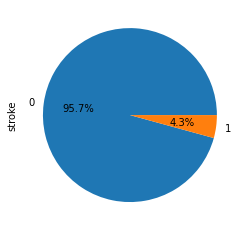

In [103]:
stroke_dataset["stroke"].value_counts().plot.pie(autopct="%.1f%%");

Dal grafico a torta della feature `stroke` notiamo che le due classi sono estremamente sbilanciate, questo protrebbe creare problemi in seguito quindi nelle prossime sezioni verranno applicate tecniche come dare un peso diverso alle due classi oppure under/over -sampling di una delle due classi

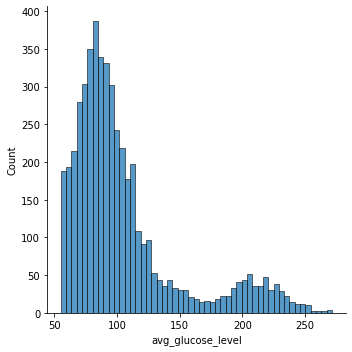

In [104]:
sb.displot(stroke_dataset["avg_glucose_level"]);

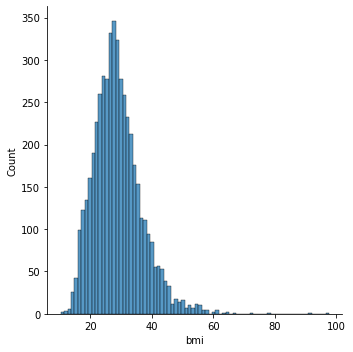

In [105]:
sb.displot(stroke_dataset["bmi"]);

Dai precedenti grafici per le distribuzioni delle feature `avg_glucose_level` e `bmi` osserviamo che:
* Il livello medio di glucosio è molto concentrato nell'intervallo che va circa da 60 a 100
* Il bmi è molto concentrato nell'intevallo [20;40]

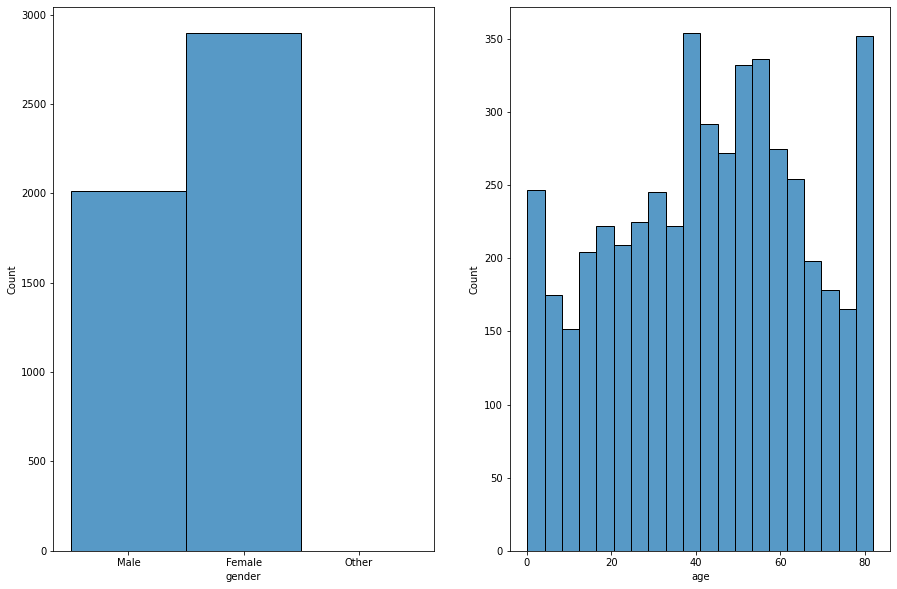

In [106]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
sb.histplot(x="gender", data=stroke_dataset);

plt.subplot(1,2,2)
sb.histplot(x="age", data=stroke_dataset);

Da questi istogrammi possiamo notare che:


* I pazienti sono più donne che uomini
* Il numero di pazienti ha due picchi intorno ai 40 anni e agli 80 anni



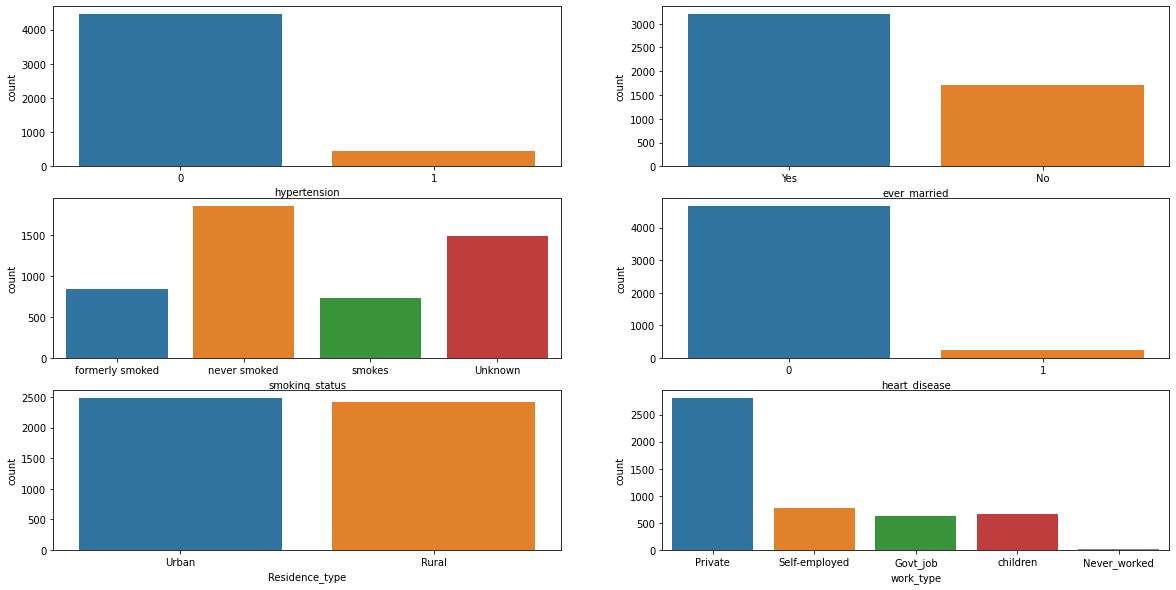

In [107]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
sb.countplot(x="hypertension", data=stroke_dataset);

plt.subplot(3,2,2)
sb.countplot(x="ever_married", data=stroke_dataset);

plt.subplot(3,2,3)
sb.countplot(x="smoking_status", data=stroke_dataset);

plt.subplot(3,2,4)
sb.countplot(x="heart_disease", data=stroke_dataset);

plt.subplot(3,2,5)
sb.countplot(x="Residence_type", data=stroke_dataset);

plt.subplot(3,2,6)
sb.countplot(x="work_type", data=stroke_dataset);


Da questi altri grafici invece notiamo che:


* Sono molti di più i pazienti senza ipertensione che quelli che ne soffrono
* Abbiamo meno pazienti che non sono mai stati sposati
* Molti dei pazienti non hanno mai fumato, però ce ne sono anche molti in cui abbiamo stato sconosciuto, quindi questo potrebbe andare a pareggiare i conti nella realtà
* Pochi pazienti sono cardiopatici
* La differenza fra chi abita in zone urbane e chi in zone rurali è pressochè nulla 



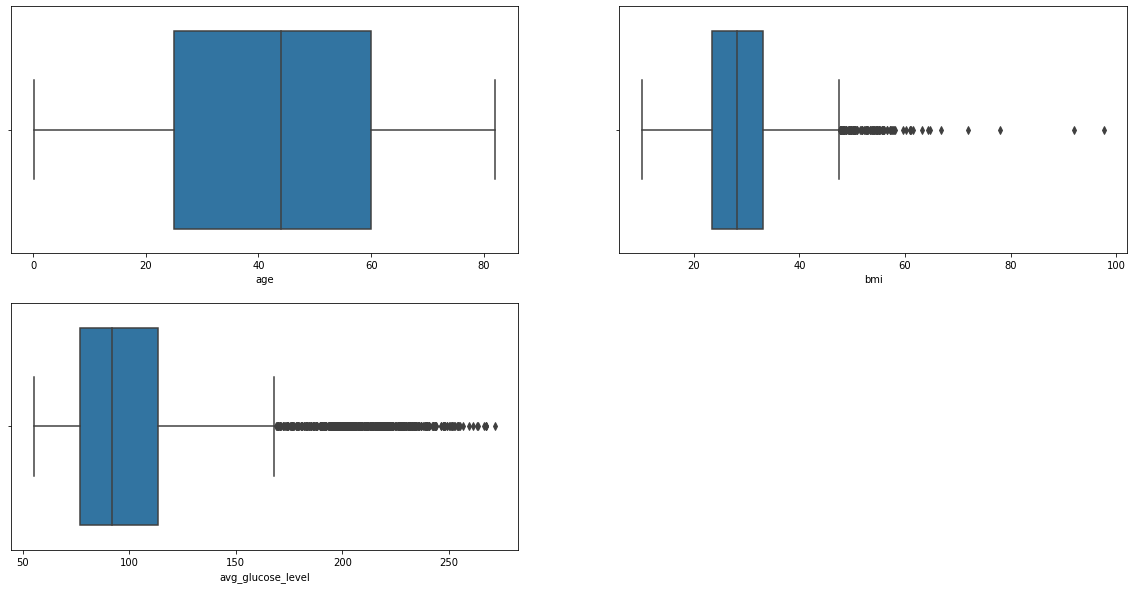

In [108]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sb.boxplot(x="age", data=stroke_dataset);

plt.subplot(2,2,2)
sb.boxplot(x="bmi", data=stroke_dataset);

plt.subplot(2,2,3)
sb.boxplot(x="avg_glucose_level", data=stroke_dataset);

Da questi ultimi grafici possiamo notare che la feature `avg_glucose_level` sembra avere molti valori outlier, a primo impatto potremmo pensare di rimuoverne almeno una parte per non avere valori anomali quindi facciamo un'analisi più approfondita per decidere se è il caso di farlo o no

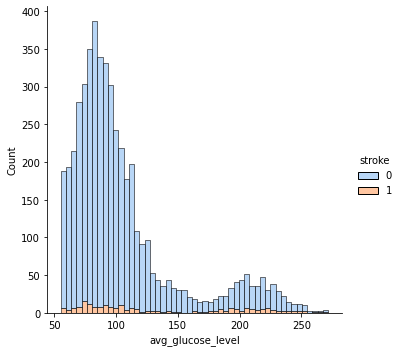

In [109]:
sb.displot(x='avg_glucose_level', hue='stroke', data = stroke_dataset, palette="pastel", multiple="stack");

In [110]:
stroke_avg165 = stroke_dataset[stroke_dataset.avg_glucose_level >= 160].loc[:,"stroke"].sum()
stroke_tot = stroke_dataset.loc[:,"stroke"].sum()
stroke_perc = stroke_avg165 / stroke_tot
print(f"Abbiamo {stroke_tot} ictus totali, di cui {stroke_avg165} sono avvenuti in pazienti con un valore di glucosio medio nel sangue non nella norma, in percentuale sono quindi il {stroke_perc:.1%}")

Abbiamo 209 ictus totali, di cui 76 sono avvenuti in pazienti con un valore di glucosio medio nel sangue non nella norma, in percentuale sono quindi il 36.4%


Da questa ulteriore analisi possiamo quindi osservare due cose:


1.   Una buona fetta degli ictus totali è presente in persone con il livello medio di glucosio nel sangue non nella norma
2.   Se consideriamo due frazioni distinte del dataset, nella prima sezione contenente i pazienti con un livello di glucosio medio inferiore a 160 abbiamo che i casi di ictus sono una piccola frazione dei casi totali mentre nella seconda sezione i casi con ictus sono una frazione molto più grande dei casi totali 

In virtù di questi risultati decidiamo di tenere anche i dati outlier per la feature `avg_glucose_level`




###Esplorazione dei legami fra le feature

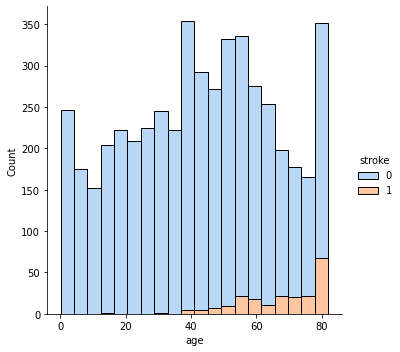

In [111]:
sb.displot(x='age', hue='stroke', data = stroke_dataset, palette="pastel", multiple="stack");

Un primo legame interessante è quello fra età e presenza di ictus, possiamo notare come praticamente la totalità degli ictus si sia verificata in pazienti con più di 35-40 anni.
In particolare abbiamo un picco nei pazienti più anziani intorno agli 80 anni

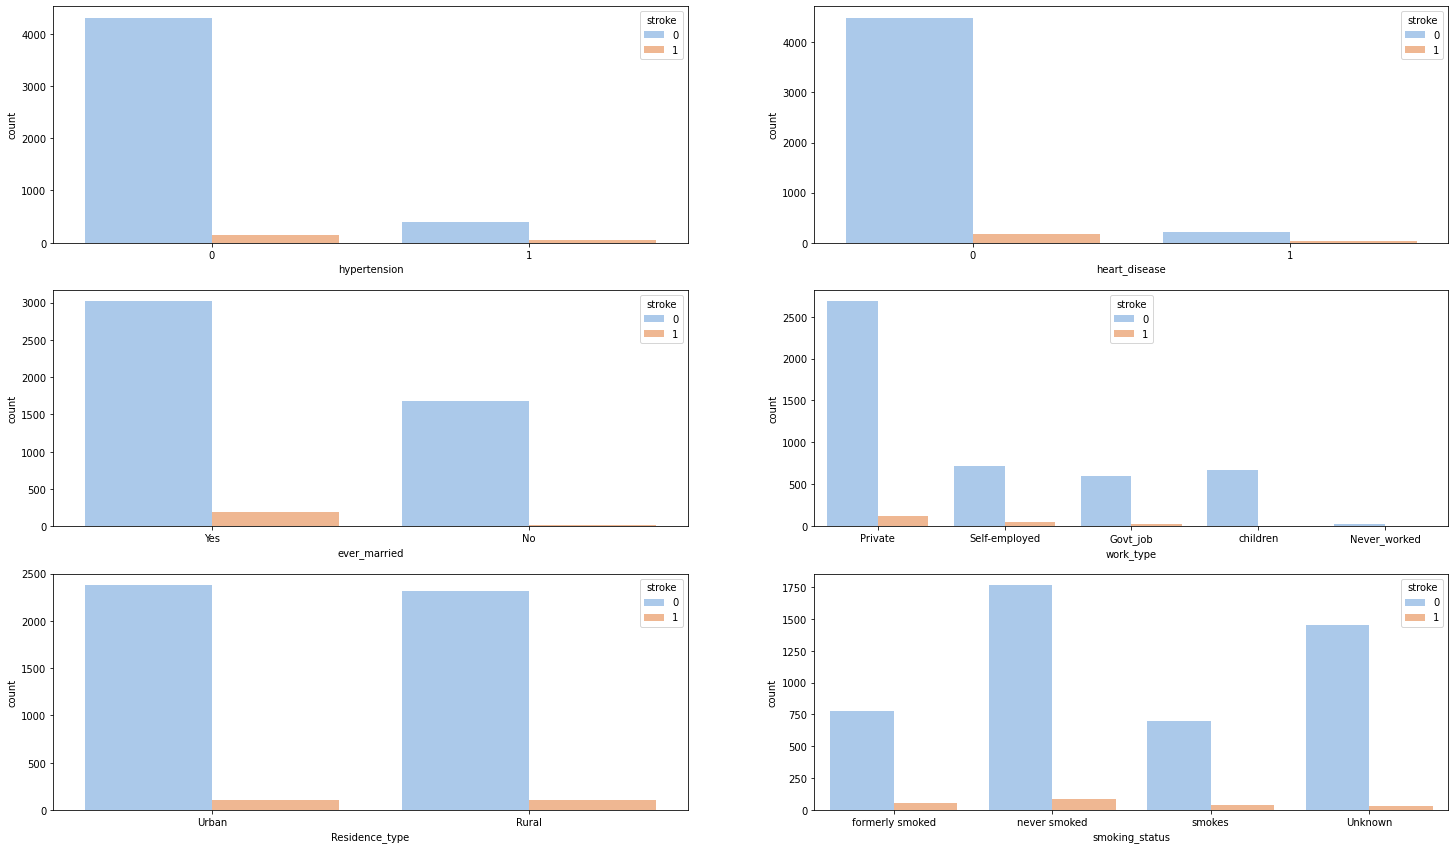

In [112]:
plt.figure(figsize=(25,20))

plt.subplot(4,2,1)
sb.countplot(x='hypertension', hue='stroke', data = stroke_dataset, palette="pastel");

plt.subplot(4,2,2)
sb.countplot(x='heart_disease', hue='stroke', data = stroke_dataset, palette="pastel");

plt.subplot(4,2,3)
sb.countplot(x='ever_married', hue='stroke', data = stroke_dataset, palette="pastel");

plt.subplot(4,2,4)
sb.countplot(x='work_type', hue='stroke', data = stroke_dataset, palette="pastel");

plt.subplot(4,2,5)
sb.countplot(x='Residence_type', hue='stroke', data = stroke_dataset, palette="pastel");

plt.subplot(4,2,6)
sb.countplot(x='smoking_status', hue='stroke', data = stroke_dataset, palette="pastel");

Notiamo quindi che:


*   Ipertensione e cardiopatia sembrano influire abbastanza sugli ictus
*   Molti dei pazienti che hanno presentato ictus erano sposati
*   La distribuzione rispetto alla zona di residenza è uniforme, circa metà e metà
*   Abitudini scorrette con il fumo possono incidere sulla presenza di ictus
*   La maggior parte dei pazienti con ictus lavorava nel settore privato o era un lavoratore autonomo




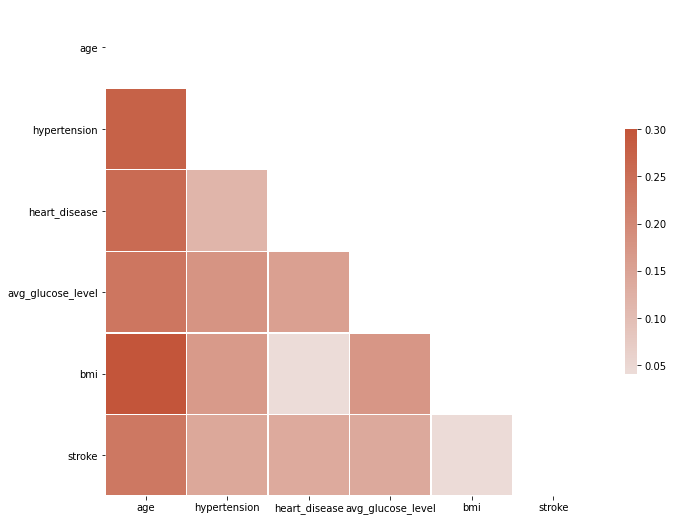

In [113]:
corr_matrix = stroke_dataset.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sb.diverging_palette(230,20,as_cmap=True)
sb.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

#credits: https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=correlation%20matrix

Da questa matrice di correlazione possiamo osservare che:


*   L'età sembra influire in modo abbastanza uguale su tute le altre feature presenti 
*   Gli ictus sono correlati in modo più forte con l'età, in minor modo con ipertensione, cardiopatia e glucosio mentre molto meno con il bmi
*   È probabile che chi ha un livello medio di glucosio nel sangue più alto abbia anche problemi di ipertensione e/o cardiopatia

*Comunque i valori di correlazione non sono molto alti quindi probabilmente sarà necessario usare modelli con feature non lineari*



##Feature Engineering

Andiamo ora a trasformare le varie feature categoriche, queste verranno splittate creando tante feature quanti sono i possibili valori che potevano assumere


*   Ad esempio la feature `Residence_type` poteva assumere valori *Urban* o *Rural* quindi verranno create due nuove feature `Residence_type_Urban` e `Residence_type_Rural`, se una determinata istanza aveva valore Urban ora avrà valore 1 nella rispettiva feature e valore 0 nell'altra

In egual modo vengono trasformate tutte le altre feature categoriche




In [114]:
categorical_features = ["gender", "work_type", "Residence_type", "smoking_status"]
stroke_dataset = pd.get_dummies(stroke_dataset, columns=categorical_features, prefix=categorical_features)

In [115]:
stroke_dataset.head(10)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,,,,,
9046,67.0,0,1,Yes,228.69,36.6,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
31112,80.0,0,1,Yes,105.92,32.5,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
60182,49.0,0,0,Yes,171.23,34.4,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
1665,79.0,1,0,Yes,174.12,24.0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0
56669,81.0,0,0,Yes,186.21,29.0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
53882,74.0,1,1,Yes,70.09,27.4,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
10434,69.0,0,0,No,94.39,22.8,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
60491,78.0,0,0,Yes,58.57,24.2,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0
12109,81.0,1,0,Yes,80.43,29.7,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0


Un altro aspetto da considerare è che la feature `ever_married` assume valori *Yes* e *No*, quindi andremo a modificarla applicando la seguente trasformazione:
* Yes = 1
* No = 0

In [116]:
stroke_dataset["ever_married"] = np.where(stroke_dataset["ever_married"] == "Yes", 1, 0)

In [117]:
stroke_dataset.head(10)

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,,,,,
9046,67.0,0,1,1,228.69,36.6,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
31112,80.0,0,1,1,105.92,32.5,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
60182,49.0,0,0,1,171.23,34.4,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
1665,79.0,1,0,1,174.12,24.0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0
56669,81.0,0,0,1,186.21,29.0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
53882,74.0,1,1,1,70.09,27.4,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
10434,69.0,0,0,0,94.39,22.8,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0
60491,78.0,0,0,1,58.57,24.2,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0
12109,81.0,1,0,1,80.43,29.7,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0


In questo modo abbiamo ottenuto tutte feature numeriche su cui possiamo lavorare agilmente

Applichiamo una tecnica di oversampling al dataset per ottenere un bilanciamento delle classi

In [118]:
sm = SMOTE(random_state=42)
y = stroke_dataset["stroke"]
X = stroke_dataset.drop("stroke", axis=1)
X_res, y_res = sm.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dal seguente grafico notiamo che ora le classi sono bilanciate

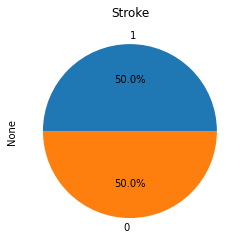

In [119]:
pd.value_counts(y_res).plot.pie(autopct="%.1f%%", title="Stroke");

Andiamo ora a suddividere i dati in training set e validations set

In [120]:
X_train, X_val, y_train, y_val = train_test_split(
    X_res,y_res,
    test_size = 1/3,
    random_state = 42
)

Applichiamo una standardiddazione dei dati

In [121]:
scaler = StandardScaler()
X_train_S = scaler.fit_transform(X_train)
X_val_S = scaler.transform(X_val)

In tutti i modelli in cui verrà applicata la `Grid Search` useremo una divisione con la classe `StratifiedKFold` in modo da avere in ogni sub-fold la stessa distribuzione per i dati

La seguente funzione calcola l'intervallo di accuratezza per un modello di classificazione con confidenza al 95% dato l'f-1 score secondo la seguente formula: 
$$ p = \frac{f + \frac{z^2}{2N} \pm z \sqrt{\frac{f}{N} - \frac{f^2}{N} + \frac{z^2}{4N^2}  }  }{1+\frac{z^2}{N}}  $$


In [122]:
def accuracy_interval(f):
  N = len(y_val)
  n_min = f + ( 1.96**2/(2*N) - 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  n_max = f + ( 1.96**2/(2*N) + 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  d = 1 + (1.96**2 / N)
  e_min = n_min / d
  e_max = n_max / d
  return np.round(e_min,4), np.round(e_max,4)

Creo un dizionario vuoto in cui man mano inserirò i valori f1-score di ogni modello in modo da poter fare un confronto finale

In [123]:
accuracy = {}

##Perceptron

In [124]:
model = Perceptron(random_state=42)
model.fit(X_train_S, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [125]:
y_pred = model.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0,1
0,1170,417
1,389,1158


In [126]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.7504810776138551, recall: 0.7372400756143668, f1-score: 0.7428169058825398


In [127]:
i = accuracy_interval(f1)
accuracy["Perceptron"] = i
print(i)

(0.7272, 0.7578)


Aggiungiamo GridSearch e CrossValidation

In [128]:
model = Perceptron(random_state=42)
parameters = {
    "penalty": [None, "l1", "l2", "elasticnet"],
    "alpha": np.logspace(-4, 0, 5),
    "tol": np.logspace(-9, 6, 6)
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_S, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Perceptron(alpha=0.0001, class_weight=None,
                                  early_stopping=False, eta0=1.0,
                                  fit_intercept=True, max_iter=1000,
                                  n_iter_no_change=5, n_jobs=None, penalty=None,
                                  random_state=42, shuffle=True, tol=0.001,
                                  validation_fraction=0.1, verbose=0,
                                  warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'penalty': [None, 'l1', 'l2', 'elasticnet'],
                         'tol': array([1.e-09, 1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [129]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
30,0.019622,0.004117,0.001059,0.000030,0.001,l1,1e-09,"{'alpha': 0.001, 'penalty': 'l1', 'tol': 1e-09}",0.757300,0.780756,0.742816,0.760291,0.015633,1
31,0.023239,0.004066,0.002132,0.001516,0.001,l1,1e-06,"{'alpha': 0.001, 'penalty': 'l1', 'tol': 1e-06}",0.757300,0.780756,0.742816,0.760291,0.015633,1
32,0.021980,0.007194,0.001096,0.000072,0.001,l1,0.001,"{'alpha': 0.001, 'penalty': 'l1', 'tol': 0.001}",0.757300,0.780756,0.742816,0.760291,0.015633,1
47,0.012465,0.002032,0.001132,0.000146,0.001,elasticnet,1e+06,"{'alpha': 0.001, 'penalty': 'elasticnet', 'tol...",0.745333,0.732408,0.760057,0.745933,0.011296,4
46,0.010388,0.000166,0.001123,0.000136,0.001,elasticnet,1000,"{'alpha': 0.001, 'penalty': 'elasticnet', 'tol...",0.745333,0.732408,0.760057,0.745933,0.011296,4


In [130]:
gs.best_params_

{'alpha': 0.001, 'penalty': 'l1', 'tol': 1e-09}

In [131]:
print(f'Best score: {round(gs.best_score_ * 100, 4):.4f}%')

Best score: 76.0291%


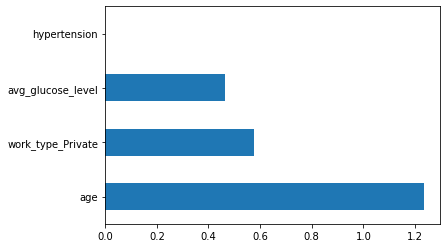

In [132]:
pc_imp = pd.Series(gs.best_estimator_.coef_[0], index=X.columns)
pc_imp.nlargest(4).plot(kind='barh');

A seguito della penalizzazione l1, che la GridSearch identifica come parametro migliore, notiamo che le feature più rilevanti sono:


*   Età
*   Tipo di lavoro: privato
*   Livello medio di glucosio nel sangue



In [133]:
y_pred = gs.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,1315,272
1,655,892


In [134]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.6675126903553299, recall: 0.8286074354127284, f1-score: 0.6987234402641411


In [135]:
i = accuracy_interval(f1)
accuracy["Perceptron with gs"] = i
print(i)

(0.6824, 0.7145)


In [136]:
perceptron_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(perceptron_mse))

MSE: 0.295788130185067


##Logistic regression

In [137]:
model = LogisticRegression(random_state=42, solver="saga")

In [138]:
model.fit(X_train_S, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
y_pred = model.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

,0,1
0,1210,377
1,295,1252


In [140]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.8039867109634552, recall: 0.7624448645242596, f1-score: 0.785539020011014


In [141]:
i = accuracy_interval(f1)
accuracy["Logistic Regression"] = i
print(i)

(0.7708, 0.7996)


In [142]:
model = LogisticRegression(random_state=42, solver="saga")
parameters = {
    "penalty": ["l1"],
    "C": [0.3, 0.8, 1],#np.logspace(-4, 0, 5),
    "tol": np.logspace(-9, 6, 6)
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_S, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.3, 0.8, 1], 'penalty': ['l1'],
                         'tol': array([1.e-09, 1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [143]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.041481,0.004075,0.002396,0.001940,0.8,l1,0.001,"{'C': 0.8, 'penalty': 'l1', 'tol': 0.001}",0.791766,0.791288,0.765805,0.782953,0.012127,1
7,0.200596,0.003740,0.002223,0.001305,0.8,l1,1e-06,"{'C': 0.8, 'penalty': 'l1', 'tol': 1e-06}",0.791288,0.791288,0.765805,0.782793,0.012013,2
6,0.202260,0.001842,0.002071,0.001162,0.8,l1,1e-09,"{'C': 0.8, 'penalty': 'l1', 'tol': 1e-09}",0.791288,0.791288,0.765805,0.782793,0.012013,2
14,0.040008,0.004562,0.000992,0.000012,1,l1,0.001,"{'C': 1, 'penalty': 'l1', 'tol': 0.001}",0.791766,0.791288,0.765326,0.782793,0.012353,4
13,0.203524,0.004758,0.004655,0.002174,1,l1,1e-06,"{'C': 1, 'penalty': 'l1', 'tol': 1e-06}",0.791766,0.791288,0.765326,0.782793,0.012353,4


In [144]:
gs.best_params_

{'C': 0.8, 'penalty': 'l1', 'tol': 0.001}

In [145]:
print(f'Best score: {round(gs.best_score_ * 100, 4):.4f}%')

Best score: 78.2953%


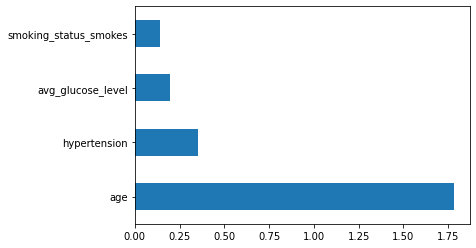

In [146]:
pc_imp = pd.Series(gs.best_estimator_.coef_[0], index=X.columns)
pc_imp.nlargest(4).plot(kind='barh');

In [147]:
y_pred = gs.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,1209,378
1,294,1253


In [148]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.8043912175648703, recall: 0.7618147448015122, f1-score: 0.7855352636756341


In [149]:
i = accuracy_interval(f1)
accuracy["Logistic regression with gs"] = i
print(i)

(0.7708, 0.7996)


In [150]:
logisticregression_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(logisticregression_mse))

MSE: 0.21442246330567966


##SVM

In [151]:
model = SVC()
parameters = {
    "kernel": ["rbf"],
    "C": np.logspace(-2, 0, 3)
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_S, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.01, 0.1 , 1.  ]), 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [152]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.405385,0.006832,0.141135,0.001930,1,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.933940,0.923887,0.924330,0.927385,0.004638,1
1,0.676020,0.007561,0.238861,0.003836,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.879847,0.885112,0.861590,0.875516,0.010079,2
0,1.026985,0.032415,0.365636,0.003265,0.01,rbf,"{'C': 0.01, 'kernel': 'rbf'}",0.785543,0.788894,0.780172,0.784870,0.003592,3


In [153]:
gs.best_params_

{'C': 1.0, 'kernel': 'rbf'}

In [154]:
print(f'Best score: {round(gs.best_score_ * 100, 4):.4f}%')

Best score: 92.7385%


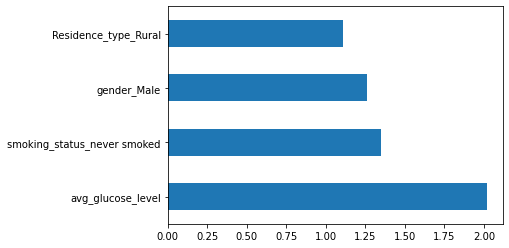

In [155]:
svm_imp = pd.Series(gs.best_estimator_.support_vectors_[0], index=X.columns)
svm_imp.nlargest(4).plot(kind='barh');

In [156]:
y_pred = gs.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,1536,51
1,162,1385


In [157]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9045936395759717, recall: 0.9678638941398866, f1-score: 0.9318775955681893


In [158]:
i = accuracy_interval(f1)
accuracy["Support Vector Machines"] = i
print(i)

(0.9225, 0.9402)


In [159]:
svm_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(svm_mse))

MSE: 0.06796426292278239


##Decision tree

I parametri che andiamo a testare nella grid search sono:
- `min_samples_split` che è il numero minimo di campioni che deve avere una foglia per poter essere splittata
- `min_samples_leaf` numero minimo di campioni per ogni foglia (i.e. se splittiamo un nodo questo split è valido solo se lascia in ogni foglia che crea almeno min_samples_leaf campioni)
- `max_depth` profondità massima che può raggiungere l'albero (con `None` cresce senza limiti su questo parametro)
- `max_features` il numero massimo di feature da considerare per ogni split

In [160]:
model = DecisionTreeClassifier(random_state=42)

num_features = X_train_S.shape[1]

parameters = {
             'min_samples_split': range(2, 4, 1),
             'min_samples_leaf': range(1, 4, 1), 
             'max_depth': [None] + [i for i in range(2, 7)],
             'max_features': range(2, num_features, 1)}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_S, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
          

In [161]:
gs.best_score_

0.9521222581092837

In [162]:
y_pred = gs.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,1532,55
1,110,1437


In [163]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9330085261875761, recall: 0.9653434152488973, f1-score: 0.9473032063508854


In [164]:
i = accuracy_interval(f1)
accuracy["Decision tree"] = i
print(i)

(0.9389, 0.9546)


In [165]:
decisiontree_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(decisiontree_mse))

MSE: 0.05264837268666241


###Visualizzazione dell'albero decisionale


Nei nodi troviamo:

- Il criterio con cui viene effettuato il taglio 


- Il parametro `gini` che indica la qualità della suddivisione, rappresenta la frequenza con cui un elemento scelto casualmente dall'insieme verrebbe etichettato in modo errato se fosse etichettato casualmente in base alla distribuzione delle etichette nel sottoinsieme, è calcolato come:
$$Gini = 1 - \sum_{i=1}^C p_i^2 $$

  $\Rightarrow$ Assume valore 0 quando tutte le istanze nel nodo hanno una stessa label

- Il parametro `samples` che indica la percentuale di campioni presenti in quel nodo
- Il parametro `value` che indica la percentuale di istanze per ogni classe

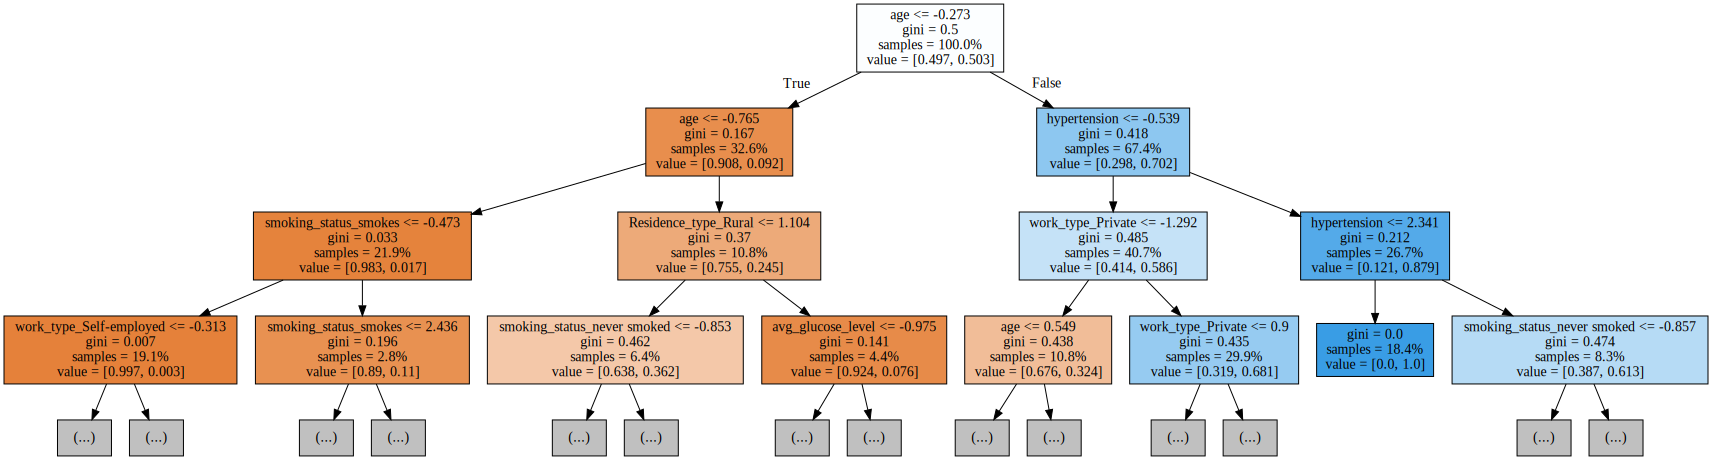

In [166]:
dot_data = tree.export_graphviz(gs.best_estimator_, out_file=None, 
                                feature_names=X.columns,  
                                filled=True,
                                proportion=True,
                                max_depth=3)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

##XGBoost

In [167]:
model = XGBClassifier(nthread=8, objective='binary:logistic')


parameters = {
    'eta': [0.002, 0.1, 0.5],
    'max_depth': [6],
    'n_estimators': [150, 300],
    'alpha': [0.0001, 0.001]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_S, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=8, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001], 'eta': [0.002, 0.1, 0.5],
                         'max_dep

In [168]:
gs.best_score_

0.9720719031208294

In [169]:
y_pred = gs.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,1579,8
1,78,1469


In [170]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9529269764634882, recall: 0.9949590422180214, f1-score: 0.9725251828365269


In [171]:
i = accuracy_interval(f1)
accuracy["XGBoost"] = i
print(i)

(0.9662, 0.9777)


In [172]:
xgboost_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(decisiontree_mse))

MSE: 0.05264837268666241


##Model comparison

Prendiamo una confidenza del 95%, di conseguenza dalla tabella della distribuzione z otteniamo 1.96 come valore per `z` 

La seguente funzione implementa il confronto fra due modelli dati i rispettivi errori `e1` ed `e2` e la cardinalità del test set `n` secondo le formule :

$$ d = |e_1 - e_2| $$

$$ \sigma_t^2 = \sigma_1^2 + \sigma_2^2 = \frac{e_1(1-e_1)}{n}  + \frac{e_2(1-e_2)}{n}$$

$$d_t = d \pm z_{1-\alpha} \cdot \sigma_t$$

In [173]:
def intervallo(mse1, mse2):
  d = np.abs(mse1 - mse2)
  variance = (mse1 * (1 - mse1)) / len(X_val) + (mse2 * (1 - mse2)) / len(X_val)
  d_min = d - 1.96 * np.sqrt(variance)
  d_max = d + 1.96 * np.sqrt(variance)
  return d_min, d_max

Andiamo a calcolare l'intervallo fra tutte le coppie di modelli

In [174]:
from itertools import combinations
mse = [("perceptron_mse", "Perceptron"), ("logisticregression_mse","Logistic Regression"),
       ("svm_mse", "SVM"), ("decisiontree_mse", "Decision Tree"), ("xgboost_mse", "XGBoost")]

print (f"{'Models':<40} {'Interval':<15}")
for m1, m2 in list(combinations(mse, 2)):
  mse1, mse2 = eval(m1[0]), eval(m2[0])
  name1, name2 = m1[1], m2[1]
  comparison = name1 + " vs " + name2
  print (f"{comparison:<40} {np.round(intervallo(mse1 , mse2), 4)} ")

Models                                   Interval       
Perceptron vs Logistic Regression        [0.0599 0.1029] 
Perceptron vs SVM                        [0.2096 0.2461] 
Perceptron vs Decision Tree              [0.2254 0.2609] 
Perceptron vs XGBoost                    [0.2514 0.2853] 
Logistic Regression vs SVM               [0.1296 0.1633] 
Logistic Regression vs Decision Tree     [0.1454 0.1781] 
Logistic Regression vs XGBoost           [0.1715 0.2024] 
SVM vs Decision Tree                     [0.0035 0.0271] 
SVM vs XGBoost                           [0.03  0.051] 
Decision Tree vs XGBoost                 [0.0155 0.0349] 


###Confronto con un modello casuale

La seguente funzione calcola, come la precedente, l'intervallo per il confronto fra due modelli ma utilizza una confidenza al 99% invece del 95%

In [175]:
def intervallo99(mse1, mse2):
  d = np.abs(mse1 - mse2)
  variance = (mse1 * (1 - mse1)) / len(X_val) + (mse2 * (1 - mse2)) / len(X_val)
  d_min = d - 2.58 * np.sqrt(variance)
  d_max = d + 2.58 * np.sqrt(variance)
  return d_min, d_max

In [176]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train_S, y_train)
y_pred = random.predict(X_val_S)
print(random.score(X_val_S, y_val))

0.5028717294192725


In [177]:
mse_random = mean_squared_error(y_val, y_pred)
print(mse_random)

0.4971282705807275


In [178]:
print (f"{'Models':<40} Interval")
for m in mse:
  mse_i = eval(m[0])
  name_i = m[1]
  comparison = name_i + " vs Random"
  print (f"{comparison:<40} {np.round(intervallo99(mse_i , mse_random), 4)} ")

Models                                   Interval
Perceptron vs Random                     [0.1701 0.2325] 
Logistic Regression vs Random            [0.2529 0.3125] 
SVM vs Random                            [0.4034 0.455 ] 
Decision Tree vs Random                  [0.4192 0.4697] 
XGBoost vs Random                        [0.4454 0.4939] 


Possiamo vedere come la differenza fra tutti i modelli e uno random sia sempre statisticamente significativa quindi i modelli implementati sono tutti accettabili 

##Conclusioni

Dalla precedente sezione *Model Comparison* possiamo vedere che fra tutti i modelli la differenza è stasticamente significativa.

Riassunto dei vari f1-score:

In [179]:
print (f"{'Model':<40} f-1 score")
for k in accuracy.keys():
    print(f"{k:<40} {accuracy[k]}")

Model                                    f-1 score
Perceptron                               (0.7272, 0.7578)
Perceptron with gs                       (0.6824, 0.7145)
Logistic Regression                      (0.7708, 0.7996)
Logistic regression with gs              (0.7708, 0.7996)
Support Vector Machines                  (0.9225, 0.9402)
Decision tree                            (0.9389, 0.9546)
XGBoost                                  (0.9662, 0.9777)


Visti i risultati ottenuti per l'indice *f1-score* per i vari modelli si può dire che i migliori sono:
- SVM con kernel RBF non lineare
- Decision tree
- XGBoost

Questo probabilmente è dovuto al fatto che inizialmente la correlazione fra le 11 feature di input è abbastanza bassa quindi usando modelli non lineari andiamo a separare meglio i dati.

Questo lo si può notare anche dal fatto che se implementiamo un modello SVM con kernel lineare otteniamo un f-1 score molto più basso (come si vede nell'esempio di seguito) 

In [180]:
model = SVC()
parameters = {
    "kernel": ["linear"],
    "C": np.logspace(-2, 0, 3)
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_S, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.01, 0.1 , 1.  ]), 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [181]:
y_pred = gs.predict(X_val_S)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,1183,404
1,272,1275


In [182]:
X_val.shape

(3134, 20)

In [183]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")
print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.8130584192439863, recall: 0.7454316320100819, f1-score: 0.7841151753117035
